[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/bondaleksey/training-ML-projects/blob/main/compare_GB_models/Compare_GB_models_on_IBM_dataset.ipynb)

# от Бондаренко Алексея (bondaleksey@gmail.com)

Цель данного ноутбука на тестовом наборе данных провести сравнение 4-ех моделей градиентного бустинга:  GradientBoosting(sklearn), XGBoost, CatBoost, LightGBM

Основные пункты задания: 

*   исследовательский анализ данных,
*   предобработка данных,
*   применение моделей с гиперпараметрами по умолчанию и проверка качества,
*   настройка гиперпараметров моделей и проверка качества.

In [1]:
import numpy as np 
import pandas as pd

# для работы с графиками 
import matplotlib.pyplot as plt 
import seaborn as sns

# sklearn 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

# for preprocessing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Boosts
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#technical 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import contextlib
import time

# 1 Данные


## 1.1 Кратко о наборе данных
В качестве данных используется набор [IBM Watson Marketing Data Analysis](https://www.kaggle.com/pankajjsh06/ibm-watson-marketing-customer-value-data). 

В конкурсе Kaggle для данного набора данных требовалось провести анализ поведения состоятельных клиентов и сделать предложения о том, как постороить программу удержания клиентов. При решении этой задачи полезным будет:

 - умение предсказывать продление контракта клиентом, 
 - выделить ключевые параметры, определяющие продления контракта клиентом.
 
Поэтому при решении основных пунктов задания будем решать задача классификации клиента по признаку `Response`. 

## 1.2 Загрузка данных

In [2]:
filename = "../data/IBM_Watson_mcva.csv"
df = pd.read_csv(filename)
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [3]:
df.shape

(9134, 24)

# 2 Исследовательский анализ данных (EDA)



## 2.1 Первичная статистика

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

В данном наборе данных 
  
*   нет NaN значений
*   8 количественных переменных
*   16 категориальных переменных




In [5]:
df.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


## 2.2 Разобьем признаки на категориальные и количественные

In [6]:
# названия категориальных переменных, которые создатут не более
# N_unique дополнительных столбцов при onehotencoding 

N_unique = 4 # может сильно влиять на работу с деревьями
             # при небольшом наборе данных, с другой стороны,
             # можем потерять один из ключевых признаков 
    
categorical_cols = [cname for cname in df.columns if
                    df[cname].nunique() < N_unique and 
                    df[cname].dtype == "object"]

# названия количественных переменных
numerical_cols = [cname for cname in df.columns if 
                df[cname].dtype in ['int64', 'float64']]


columns_for_drop=list(set(df.columns) - set(numerical_cols) - set(categorical_cols))
print(type(columns_for_drop))
print(columns_for_drop)

print(f"Число категориальных переменных: {len(categorical_cols)}")
print(f"Число количесвтенных переменных: {len(numerical_cols)}")
print(f"Из рассмотрения исключены: {len(columns_for_drop)} категориальных переменных ")

<class 'list'>
['Sales Channel', 'State', 'Education', 'EmploymentStatus', 'Effective To Date', 'Policy', 'Renew Offer Type', 'Customer', 'Vehicle Class']
Число категориальных переменных: 7
Число количесвтенных переменных: 8
Из рассмотрения исключены: 9 категориальных переменных 


### 2.2.1 Анализ количественных данных

В рамках данной работы приведены:
- гистограммы плотности распределения для количесвенных перемнных,
- точечные графики зависимости CLV от каждой  количесвенной перемнной с выделением синим цветом клиентов согласившихся на новый контракт.

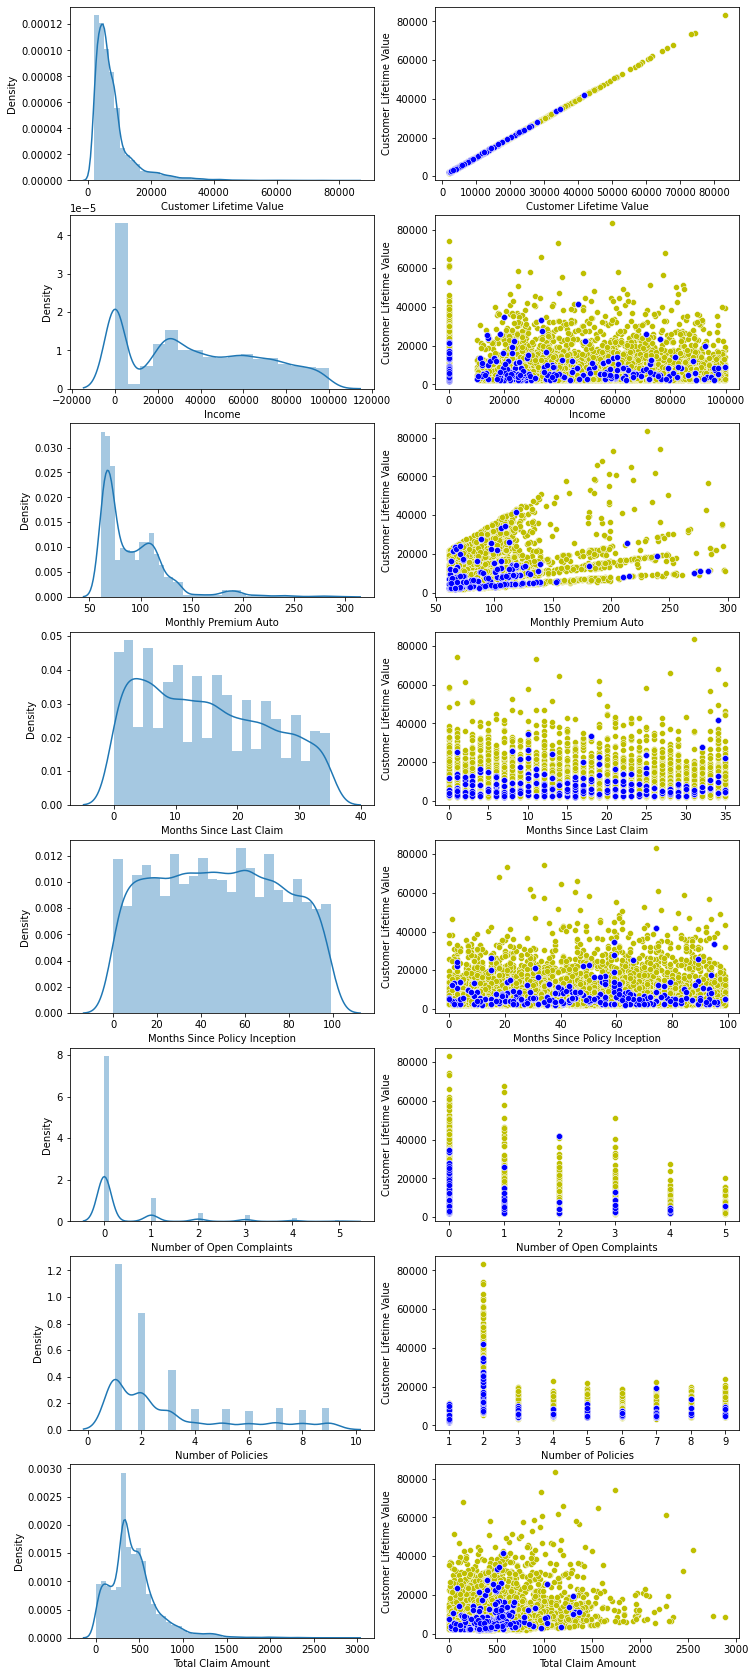

In [7]:
plt.figure(figsize=(12, 30))

for i, val in enumerate(numerical_cols):
  plt.subplot(len(numerical_cols), 2, 2*(i+1)-1)  
  sns.distplot(df[val])  
  plt.subplot(len(numerical_cols), 2, 2*(i+1))  
  sns.scatterplot(df[val][df['Response']=='No'],
                  df["Customer Lifetime Value"][df['Response']=='No'],color='y')
  sns.scatterplot(df[val][df['Response']=='Yes'],
                  df["Customer Lifetime Value"][df['Response']=='Yes'],color='b')

**Предварительный анализ количественных данных**

Из построенных графиков следует, что среди продленных контрактов большая часть это клиенты с "незначительным" CLV.
В качеcтве вариантов возможных исследований можно выделить:
 - подробное рассмотрение случаев продления контракта клиентами с высоким CLV,
 - анализ службы работы с жалобами.

### 2.2.2 Анализ категориальных параметров

В рамках данной работы для всех возможных значений категориальных  переменных приведены процентные составляющие признака `Response`.

In [8]:
#Определяем функцию, которая рисует проценты над столбцами
def annot_plot(ax):
    """Draws percentages over the bars.

    Args:
      ax: Axes object with the plot drawn onto it.
    """
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for p in ax.patches:
         ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%",
                     (p.get_x() + p.get_width() / 2., p.get_height()),                     
                     ha='center', va='center', fontsize=11,
                     color='black', rotation= 0, xytext=(0, 10),
                     textcoords='offset points') 

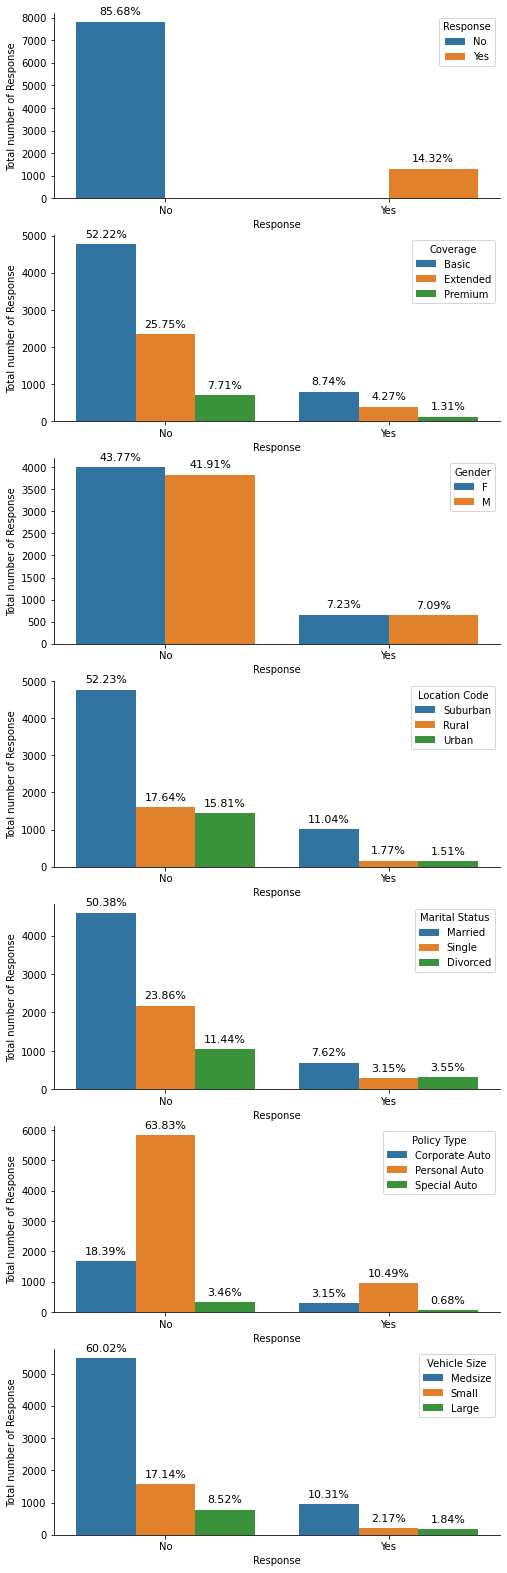

In [9]:
plt.figure(figsize=(2*N_unique,N_unique*7))

for i, val in enumerate(categorical_cols):
  plt.subplot(len(categorical_cols), 1, i+1)
  ax = sns.countplot('Response', hue = val ,data = df)
  plt.ylabel(f'Total number of Response')
  annot_plot(ax)  

**Предварительный анализ качественных данных**

 - В представленном наборе данных число отказавшихся продлевать контракт 86% сильно больше числа согласившихся продлевать контракт 14%. 
 - Надо обратить внимание на следующий признак: проживающие в пригороде. 

# 3 Предобработка данных
Выполним преобразование данных, а затем разобъем их на train-test наборы.

## 3.1 Преобразование категориальных переменных


In [10]:
# преобразование Response в численный вид
#df['Response'] = df['Response'].apply(lambda X : 0 if X == 'No' else 1)
response_enc = LabelEncoder()
df["Response"] = response_enc.fit_transform(df["Response"])

# "Response" - будет целевым признаком, поэтому
#   исключим этот признак из категориальных 
#   и не будем включать в численные.
if "Response" in categorical_cols:
    categorical_cols.remove("Response")

print("Categorical columns are:\n",categorical_cols)

Categorical columns are:
 ['Coverage', 'Gender', 'Location Code', 'Marital Status', 'Policy Type', 'Vehicle Size']


In [11]:
# преобразование данных с помощью функций pandas
def data_preprocessing(data_input, cols_4_drop, cat_cols):
    """Preprocess data by drop some columns and one hot encoding categorical columns.

    Args:
      data_input: DataFrame with input data,
      cols_4_drop: List of columns names for drop out of the input DataFrame,
      cat_cols: List of columns names for OneHotEncode in the input DataFrame.

    Returns:
      Renew DataFrame.
    """
    data_input = data_input.drop(cols_4_drop, axis=1)
    data_input = pd.get_dummies(data_input, columns=cat_cols, prefix_sep='=')    
    return data_input

In [12]:
df = data_preprocessing(df, columns_for_drop, categorical_cols)    

In [13]:
df.head()

,Customer Lifetime Value,Response,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Coverage=Basic,...,Location Code=Urban,Marital Status=Divorced,Marital Status=Married,Marital Status=Single,Policy Type=Corporate Auto,Policy Type=Personal Auto,Policy Type=Special Auto,Vehicle Size=Large,Vehicle Size=Medsize,Vehicle Size=Small
0,2763.519279,0,56274,69,32,5,0,1,384.811147,1,...,0,0,1,0,1,0,0,0,1,0
1,6979.535903,0,0,94,13,42,0,8,1131.464935,0,...,0,0,0,1,0,1,0,0,1,0
2,12887.431650,0,48767,108,18,38,0,2,566.472247,0,...,0,0,1,0,0,1,0,0,1,0
3,7645.861827,0,0,106,18,65,0,7,529.881344,1,...,0,0,1,0,1,0,0,0,1,0
4,2813.692575,0,43836,73,12,44,0,1,138.130879,1,...,0,0,0,1,0,1,0,0,1,0


## 3.2 Нормализация количественных  данных 

In [14]:
# Стандартизация (z-преобразование)  
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [15]:
df.head()

,Customer Lifetime Value,Response,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Coverage=Basic,...,Location Code=Urban,Marital Status=Divorced,Marital Status=Married,Marital Status=Single,Policy Type=Corporate Auto,Policy Type=Personal Auto,Policy Type=Special Auto,Vehicle Size=Large,Vehicle Size=Medsize,Vehicle Size=Small
0,-0.762878,0,0.612827,-0.703925,1.678099,-1.543287,-0.42225,-0.822648,-0.169640,1,...,0,0,1,0,1,0,0,0,1,0
1,-0.149245,0,-1.239617,0.022691,-0.208186,-0.217334,-0.42225,2.106160,2.400737,0,...,0,0,0,1,0,1,0,0,1,0
2,0.710636,0,0.365710,0.429596,0.288205,-0.360680,-0.42225,-0.404247,0.455734,0,...,0,0,1,0,0,1,0,0,1,0
3,-0.052263,0,-1.239617,0.371467,0.288205,0.606907,-0.42225,1.687759,0.329769,1,...,0,0,1,0,1,0,0,0,1,0
4,-0.755575,0,0.203390,-0.587666,-0.307465,-0.145661,-0.42225,-0.822648,-1.018843,1,...,0,0,0,1,0,1,0,0,1,0


## 3.3 Разбиение данных 
В качестве целевого признака выбираем `Response`. Проведем разбиение данных на train-test


 



In [16]:
# разделим на целевой вектор и вектора признаков
y = df['Response']
X = df.drop(['Response'], axis=1)

# разбиение данных на набор для обучения и сравнения
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=321, stratify=y)
print("Размерность X_train: ",X_train.shape)
print("Размерность X_test: ", X_test.shape)
print("Категориальные параметры:\n",categorical_cols)
print("Численные параметры:\n",numerical_cols)

Размерность X_train:  (5480, 25)
Размерность X_test:  (3654, 25)
Категориальные параметры:
 ['Coverage', 'Gender', 'Location Code', 'Marital Status', 'Policy Type', 'Vehicle Size']
Численные параметры:
 ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto', 'Months Since Last Claim', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount']


# 4 Модели градиентного бустинга с гиперпараметрами по умолчанию

Будем использовать следующие сокращения, по заглавным буквам в названии применяемых моделей:
- **GBC** &emsp; &nbsp;  для обозначения  *GradientBoostingClassifier* из sklearn.ensemble
- **XGBC** &ensp;&nbsp; для обозначения   *XGBClassifier* из xgboost
- **CBC** &emsp; &nbsp; для обозначения   *CatBoostClassifier* из catboost
- **LGBMC**&nbsp; для обозначения  *LGBMClassifier* из lightgbm


## 4.1 Функции обработки

Определим функции, которые осуществляют обучения и выдают предсказания записанные в датафреймы для удобного сравнения результатов работ моделей

In [17]:
@contextlib.contextmanager
def my_timer(name):    
    start = time.time()
    yield    
    end = time.time() - start
    print(f"Для {name} время вычислений составило: {end:0.2f} сек.")

In [18]:
# определим вспомогательную функцию, которая для строки возвращает заглавные символы в ней
def shorter(name):
    """Reduce string and returns uppercase symbols.

    Args:
      name: Stiring with upper case simbols.

    Returns:
      upercase simbols in the string name.
    """
    return "".join([let for let in name if let.isupper()])    

In [19]:
# определим функцию обучения и предсказания на разбиении из пункта 3.3
def single_gb_fit_predict(models, x_train, y_train, x_test, y_test):
    """Fit models to xtrain, ytrain and predict outcome for xtest.

    Args:
      models:  List with the gradient boosting classification models
      x_train: DataFrame with train data 
      y_train: PandasSeries with labels for train data 
      x_test:  DataFrame with test data 
      y_test:  PandasSeries with labels for test data 

    Returns:
      combined: DataFrame with first column with labels y_test
                and predicted values by the models for incoming x_test.
    """
    # создаем пустой DataFrame
    combined = pd.DataFrame()
    combined["y_test"] = y_test    
    for model in models:
        model.fit(x_train, y_train)        
        combined[shorter(type(model).__name__)] = model.predict(x_test)
        combined[shorter(type(model).__name__)+"_proba"] = model.predict_proba(x_test)[:,1]   
    return combined

In [20]:
# определим функцию многократного обучения, предсказания и валидации моделей
def repeated_gb_crossvalidation(models, x, y):
    """Calculate repeated stratified K-fold crossvalidation score for
       model in list models.

    Args:
      models: List with the gradient boosting classification models
      x:      DataFrame with full dataset (train+test) 
      y:      PandasSeries with labels for full dataset (train+test)
      
    Returns:
      combined: DataFrame with first column with labels y_test
                and predicted values by the models for incoming x_test.
    """    
    # будем проводить многократную валидацию моделей на одинаковых разбиениях
    combined = pd.DataFrame()
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=321) 
    for model in models: 
        with my_timer(shorter(type(model).__name__)):
            combined[shorter(type(model).__name__)] = cross_val_score(model, x, y,
                                                           scoring='roc_auc', cv=cv)
    return combined

## 4.2 Сбор результатов обучения и предсказаний моделей

In [21]:
# Определим список моделей градиентного бустинга
models = [
    GradientBoostingClassifier(),
    XGBClassifier(objective="reg:logistic"),
    CatBoostClassifier(eval_metric='AUC',verbose=0),
    LGBMClassifier()
]
#output single prediction from models with default parameters
sp_default = single_gb_fit_predict(models, X_train, y_train, X_test, y_test)
print(sp_default.head(5))

      y_test  GBC  GBC_proba  XGBC  XGBC_proba  CBC  CBC_proba  LGBMC  \
462        0    0   0.066099     0    0.004422    0   0.014607      0   
7749       0    0   0.195492     0    0.115730    0   0.212403      0   
922        0    0   0.081485     0    0.006709    0   0.014365      0   
2823       0    0   0.158187     0    0.321802    0   0.347804      0   
8304       0    0   0.067400     0    0.003900    0   0.022269      0   

      LGBMC_proba  
462      0.026268  
7749     0.180806  
922      0.018573  
2823     0.135303  
8304     0.009740  


In [22]:
#output repeated stratified K-fold crossvalidation from models with default parameters
crossval_default = repeated_gb_crossvalidation(models, X, y)
print(crossval_default.head(5))

Для GBC время вычислений составило: 20.93 сек.
Для XGBC время вычислений составило: 5.14 сек.
Для CBC время вычислений составило: 64.53 сек.
Для LGBMC время вычислений составило: 1.76 сек.
        GBC      XGBC       CBC     LGBMC
0  0.862964  0.999452  0.995743  0.998246
1  0.896825  0.999985  0.999410  0.999481
2  0.899951  1.000000  0.999800  0.999149
3  0.901596  0.999956  0.999293  0.998878
4  0.844474  0.977065  0.978909  0.980970


# 5 Настройка гиперпараметров моделей

Настройка параметров отличается для разных реализаций градиентного бустинга.
Проведем перебор из множества значений гиперпараметров базового алгоритма (определяющих деревья решений).


## 5.1 Функции обработки 

In [23]:
def find_best_params_by_grid_search(models, grid, x_train, y_train):
    """Finding best params on grid for different models on x_train, y_train.          

    Args:
      models:      List with the gradient boosting classification
                   models with dafault parameters
      grid:        Dictionary with parameters and their values
      x_train:     DataFrame with train data 
      y_train:     PandasSeries with labels for train data     

    Returns:
      best_params: List of dictionaries with best parameters on grid for models.
    """
    best_params=[]
    for model in models:
        grid_ra = GridSearchCV(estimator=model,
                                    param_grid=grid,
                                    scoring='roc_auc',
                                    cv=4,
                                    verbose=1)        
        with my_timer(shorter(type(model).__name__)):
            grid_ra.fit(x_train, y_train)        
        print(f"Лучшие значения параметров: \n{grid_ra.best_params_}",)
        print(f"Значение roc_auc: {grid_ra.best_score_:0.4f}\n")
        best_params.append(grid_ra.best_params_)
    return best_params        

In [24]:
def fit_predict_tuned_models(models, x_train, y_train, x_test, y_test):
    """Calculate predictions for x_test for different models with best parameters

    Args:
      models:   List with the gradient boosting classification models with best parameters
      x_train:  DataFrame with train data 
      y_train:  PandasSeries with labels for train data     
      x_test:   DataFrame with test data 
      y_test:   PandasSeries with labels for test data

    Returns:
      combined: DataFrame with first column with labels y_test
                and predicted values by the models for incoming x_test.
    """
    combined = pd.DataFrame()
    combined["y_test"] = y_test
    for model in models:
        model.fit(x_train,y_train)    
        combined[shorter(type(model).__name__)] = model.predict(x_test)        
        combined[shorter(type(model).__name__)+"_proba"] = model.predict_proba(x_test)[:,1]
    return combined        

## 5.2 Поиск оптимальных значений гиперпараметров

In [25]:
# зададим сетку для поиска лучших параметров 
gbm_param_grid = {
                'learning_rate': [0.03, 0.1, 0.3],
                "max_depth":     [2, 6, 9],
                'n_estimators':  [10, 50, 100],                
                'subsample':     [0.3, 0.5, 0.95],
                }
# разобъем инициализацию
# на класс (cl_models) и начальные параметры (default_params)
# для последующей инициализации моделей 
# объединением параметров по умолчанию (default_params)
# и оптимальными параметрами (best_params),
# найденными в результате перебора по сетке 
cl_models = [
    GradientBoostingClassifier,
    XGBClassifier,
    CatBoostClassifier,
    LGBMClassifier
]
default_params=[
    {},
    {"objective":"reg:logistic"},
    {"eval_metric":'AUC',"verbose":0},
    {}
]

In [26]:
# инициализация моделей параметрами по умолчанию
models = [cl_models[i](**default_params[i]) for i in range(len(cl_models))]
# поиск оптимальных параметров по сетке
best_params = find_best_params_by_grid_search(models, gbm_param_grid, X_train, y_train)

Fitting 4 folds for each of 81 candidates, totalling 324 fits
Для GBC время вычислений составило: 119.11 сек.
Лучшие значения параметров: 
{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.3}
Значение roc_auc: 0.9833

Fitting 4 folds for each of 81 candidates, totalling 324 fits
Для XGBC время вычислений составило: 24.87 сек.
Лучшие значения параметров: 
{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.95}
Значение roc_auc: 0.9817

Fitting 4 folds for each of 81 candidates, totalling 324 fits
Для CBC время вычислений составило: 85.65 сек.
Лучшие значения параметров: 
{'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.5}
Значение roc_auc: 0.9802

Fitting 4 folds for each of 81 candidates, totalling 324 fits
Для LGBMC время вычислений составило: 8.36 сек.
Лучшие значения параметров: 
{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.3}
Значение roc_auc: 0.9804



In [27]:
# инициализация моделей объединением параметрами по умолчанию и оптимальными параметрами
best_models = [cl_models[i](**{**default_params[i],
                               **best_params[i]}) for i in range(len(cl_models))]
sp_tuned = fit_predict_tuned_models(best_models, X_train, y_train, X_test, y_test)
print(sp_tuned.head(5))

      y_test  GBC  GBC_proba  XGBC  XGBC_proba  CBC  CBC_proba  LGBMC  \
462        0    0   0.010246     0    0.041974    0   0.026819      0   
7749       0    0   0.081831     0    0.191159    0   0.045268      0   
922        0    0   0.001843     0    0.012149    0   0.000021      0   
2823       0    0   0.075125     0    0.360561    0   0.042062      0   
8304       0    0   0.002178     0    0.010236    0   0.000372      0   

      LGBMC_proba  
462      0.005266  
7749     0.109274  
922      0.000337  
2823     0.399612  
8304     0.001024  


## 5.3 Результаты работы моделей на некотором не оптимальном наборе значений гиперпараметров

In [28]:
gbm_bad_params = {
    'learning_rate': 0.1,
    'max_depth':     6,
    'n_estimators':  10,
    'subsample':     0.95,
    }
some_models = [cl_models[i](**{**default_params[i],
                               **gbm_bad_params}) for i in range(len(cl_models))]
sp_not_tuned = fit_predict_tuned_models(some_models, X_train, y_train, X_test, y_test)
print(sp_not_tuned.head(5))

      y_test  GBC  GBC_proba  XGBC  XGBC_proba  CBC  CBC_proba  LGBMC  \
462        0    0   0.074514     0    0.246258    0   0.161991      0   
7749       0    0   0.186727     0    0.301742    0   0.252825      0   
922        0    0   0.125084     0    0.229849    0   0.250493      0   
2823       0    0   0.284238     0    0.365512    0   0.232691      0   
8304       0    0   0.101011     0    0.223544    0   0.230189      0   

      LGBMC_proba  
462      0.175805  
7749     0.207997  
922      0.092862  
2823     0.178093  
8304     0.100461  


# 6 Сравнение моделей градиентного бустинга

## 6.1 Функции для сравнения моделей

### 6.1.1 При единичном эксперименте

In [29]:
def get_metrics_of_single_experiment(sp_default):
    """Output some metrics for comparison of some binary classification models.

    Args:
      sp_default: DataFrame with sigle predictions for
                  some (gradient boosting classification) models                
    """
    proba_names = [name for name in sp_default.columns if "_proba" in name ]    
    model_names = [name for name in sp_default.columns if "_" not in name ]  
    
    # make classification_report for all models
    clf_reports = [classification_report(sp_default['y_test'],
                                         sp_default[model_name]
                                        ) for model_name in model_names]  
    for i, report in enumerate(clf_reports):    
        print(f"\nFor {model_names[i]:^7} we have classification report:\n", report)
        
    # make confusion_matrix for all models    
    cm = [ confusion_matrix(sp_default['y_test'],
                            sp_default[model_name]
                           ) for model_name in model_names] 
    draw_confusion_matrixs(cm, model_names)
    
    # make roc_auc_score  
    rog_auc_scores = [roc_auc_score(sp_default['y_test'],
                                    sp_default[model_name]
                                   ) for model_name in model_names]  
    for i, ra_score in enumerate(rog_auc_scores):
        print(f"For model {model_names[i]:^7} our rog_auc_score is {ra_score:0.3f} ")
        
    # make roc curves for all models    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i, proba_name in enumerate(proba_names):
        fpr[i], tpr[i], _ = roc_curve(sp_default["y_test"], sp_default[proba_name])
        roc_auc[i] = auc(fpr[i], tpr[i])   
    draw_roc_curve(fpr, tpr, roc_auc, model_names)

In [30]:
def draw_confusion_matrixs(cm, model_names):
    """Plot confusion matrics for comparison of some binary classification models.

    Args:
      cm: confusion matrics with predictions from
          some binary classification models
      model_names: list of binary classification model names  
    """     
    fig = plt.figure(figsize=(7,7))
    for i, name in enumerate(model_names):
        ax = plt.subplot(2, int((len(model_names)+1)/2), i+1)         
        ax.set_title(name) 
        df_cm = pd.DataFrame(cm[i], index = ["No", "Yes"], columns = ["No", "Yes"])    
        sns.heatmap(df_cm, annot=True)

In [31]:
def draw_roc_curve(fpr, tpr, roc_auc, model_names):
    """Plot Roc curve for comparison of some binary classification models.

    Args:
      fpr: dictionary with false positive rates of predictions
                        from some binary classification models
      tpr: dictionary with true positive rates of predictions
                       from some binary classification models
      roc_auc: dictionary with area ander roc curve of predictions
                            from some binary classification models
      model_names: list of binary classification model names
    """    
    plt.figure(figsize=(6,6))
    lw = 2
    for i, name in enumerate(model_names):
        plt.plot(fpr[i], tpr[i], lw=lw,
                 label=f"{name:^8} (area = {roc_auc[i]:0.4f})"
                )
        
    plt.plot([0, 1], [0, 1], lw=lw, color="navy", linestyle="--")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.grid(visible=True)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Roc curves for different models \n and data split in sectiion 3.3")
    plt.legend(loc="lower right")
    plt.show()   

### 6.1.2 При многократной кроссвалидации 

In [32]:
def get_metrics_of_repeated_experiment(crossval_data):
    """Output mean and std for score results of
       repeated stratified K-fold cross-validation.

    Args:
      crossval_data: DataFrame with score results of
                     repeated stratified K-fold cross-validation 
    """ 
    for name in crossval_data.columns:
        print(f"For model {name:^7} our scores mean = \
        {crossval_data[name].mean():0.4f} (+/- std = {crossval_data[name].std():0.4f})")

## 6.2 Модели с гиперпараметрами по умолчанию

### 6.2.1 Результаты при обучении на разбиении из пункта 3.3


For   GBC   we have classification report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      3131
           1       0.86      0.11      0.19       523

    accuracy                           0.87      3654
   macro avg       0.87      0.55      0.56      3654
weighted avg       0.87      0.87      0.82      3654


For  XGBC   we have classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3131
           1       0.97      0.96      0.97       523

    accuracy                           0.99      3654
   macro avg       0.98      0.98      0.98      3654
weighted avg       0.99      0.99      0.99      3654


For   CBC   we have classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      3131
           1       0.98      0.80      0.88       523

    accuracy                           0.97    

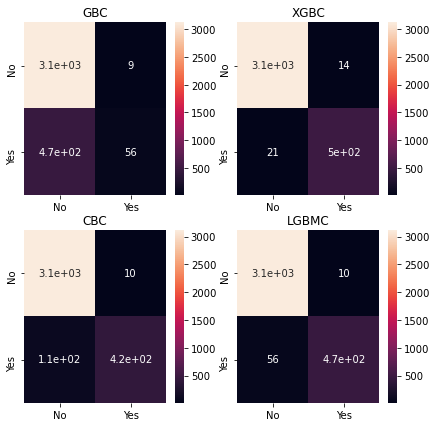

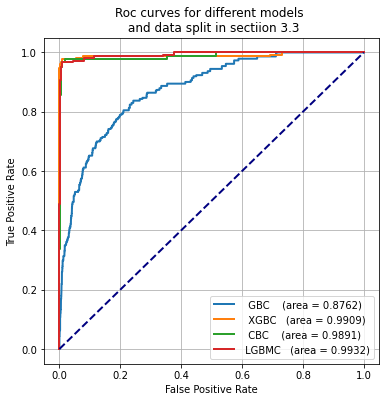

In [33]:
get_metrics_of_single_experiment(sp_default)

### 6.2.2 Результаты при множественной кроссвалидации на всем наборе данных

In [34]:
get_metrics_of_repeated_experiment(crossval_default)

For model   GBC   our scores mean =         0.8888 (+/- std = 0.0129)
For model  XGBC   our scores mean =         0.9989 (+/- std = 0.0046)
For model   CBC   our scores mean =         0.9976 (+/- std = 0.0041)
For model  LGBMC  our scores mean =         0.9981 (+/- std = 0.0037)


## 6.3 Модели и оптимизация гиперпараметров 

### 6.3.1 Результаты работы моделей на некотором не оптимальном наборе значений гиперпараметров


For   GBC   we have classification report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      3131
           1       0.86      0.10      0.18       523

    accuracy                           0.87      3654
   macro avg       0.87      0.55      0.55      3654
weighted avg       0.87      0.87      0.82      3654


For  XGBC   we have classification report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93      3131
           1       0.84      0.16      0.26       523

    accuracy                           0.87      3654
   macro avg       0.86      0.58      0.60      3654
weighted avg       0.87      0.87      0.84      3654


For   CBC   we have classification report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92      3131
           1       0.00      0.00      0.00       523

    accuracy                           0.86    

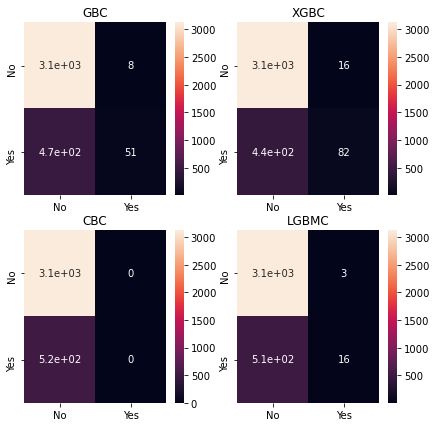

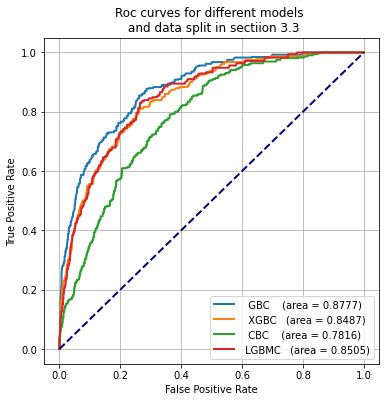

In [35]:
get_metrics_of_single_experiment(sp_not_tuned)

### 6.3.2 Результаты моделей при оптимальных гиперпараметрах 


For   GBC   we have classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3131
           1       0.99      0.97      0.98       523

    accuracy                           0.99      3654
   macro avg       0.99      0.98      0.99      3654
weighted avg       0.99      0.99      0.99      3654


For  XGBC   we have classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3131
           1       0.98      0.94      0.96       523

    accuracy                           0.99      3654
   macro avg       0.99      0.97      0.98      3654
weighted avg       0.99      0.99      0.99      3654


For   CBC   we have classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3131
           1       0.97      0.99      0.98       523

    accuracy                           0.99    

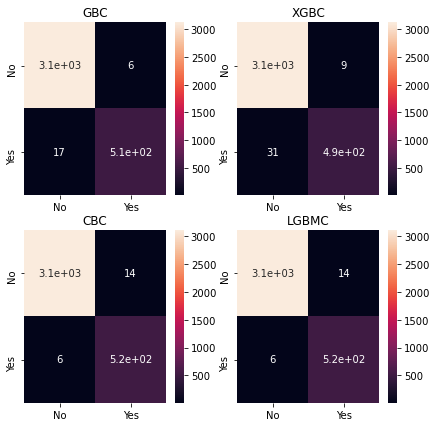

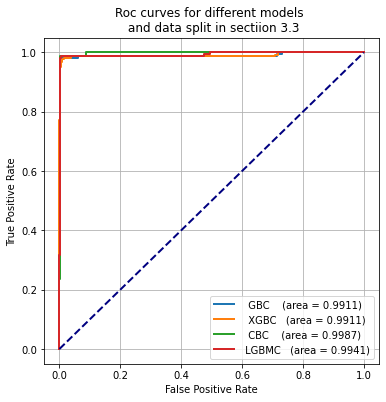

In [36]:
get_metrics_of_single_experiment(sp_tuned)

## 6.4 Значимость признаков данных для оптимальных моделей

In [37]:
def draw_models_feature_importances(models, col_names):
    """Plot feature importances of tuned models in barh figure.

    Args:
      models:    List with the gradient boosting classification
                 models with best parameters 
      col_names: List of data feature names
    """  
    single_width = 0.7
    fsize = 12
    fig = plt.figure(figsize=(fsize,int(fsize/2)))
    ax = plt.subplot(1,1,1)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']    
        
    n_bars = len(col_names)
    n_models = len(models)    
    scale=1.4
    x_vals=np.arange(n_bars)*scale
    bars=[]
    model_names = []
    # проходим по каждой модели 
    for i, model in enumerate(models):        
        model_names.append(shorter(type(model).__name__))
        norm_features = model.feature_importances_                
        if sum(norm_features)>1.00001:
            norm_features = norm_features/sum(norm_features)
        # для каждой модели столбец со своим сдвигом 
        h_offset = (i+1-n_models/2)/(n_models)        
        # строим отдельный столбец для каждого признака 
        for j, y in enumerate(norm_features):
            bar = ax.bar(x_vals[j]+h_offset, y,
                         width=0.2, color=colors[i%len(colors)])                
        bars.append(bar[0])
        
    ax.legend(bars, model_names )    
    ax.set_xticks(x_vals)
    ax.set_xticklabels( col_names, rotation=75)
    plt.xlim(scale/2+x_vals[0],x_vals[-1]+scale)
    plt.title("Feature importances for different models", fontsize=15)
    plt.ylabel("relative feature importances", fontsize=12)
    plt.xlabel("features", fontsize=12)
    plt.grid(visible=True)
    plt.show()

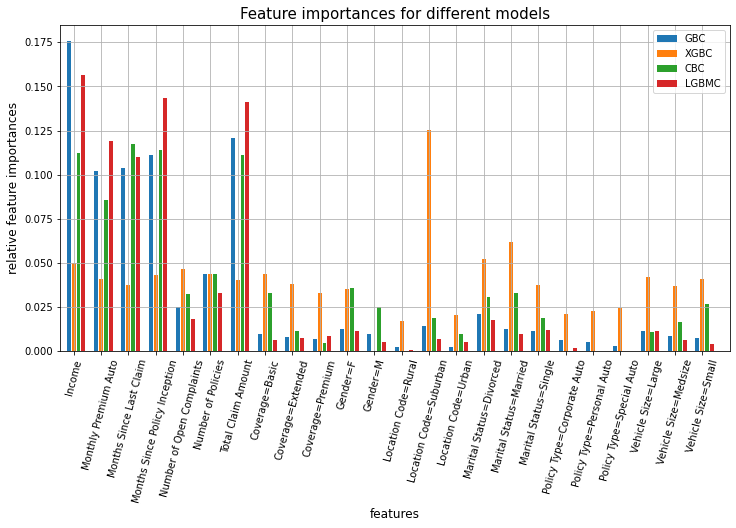

In [38]:
draw_models_feature_importances(best_models,X.columns)

In [39]:
def draw_models_feature_importances_h(models, col_names):
    """Plot feature importances of tuned models in barh figure.

    Args:
      models:    List with the gradient boosting classification
                 models with best parameters 
      col_names: List of data feature names
    """     
    fig = plt.figure(figsize=(8,16))
    ax = plt.subplot(1,1,1)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']        
    n_models = len(models)   
    # параметр, который позволяет сделать картинку разреженной (scale >= 1)
    scale=1.7
    y_vals=np.arange(len(col_names))*scale
    bars=[]
    model_names = []
    # проходим по каждой модели 
    for i, model in enumerate(models):        
        model_names.append(shorter(type(model).__name__))
        norm_features = model.feature_importances_                
        if sum(norm_features)>1.00001:
            norm_features = norm_features/sum(norm_features)
        # для каждой модели столбец со своим сдвигом 
        h_offset = (i+1-n_models/2)*scale/(n_models)        
        # строим отдельный столбец для каждого признака 
        for j, feature in enumerate(norm_features):
            barh = ax.barh(y_vals[j]+h_offset, feature,
                           height=0.3, color=colors[i%len(colors)])                
        bars.append(barh[0])
        
    ax.legend(bars, model_names)
    ax.set_yticks(y_vals)
    ax.set_yticklabels(col_names)
    plt.ylim(-scale/2+y_vals[0],y_vals[-1]+scale)
    plt.title("Feature importances for different models", fontsize=18)
    plt.xlabel("relative feature importances", fontsize=15)
    plt.ylabel("features", fontsize=15)
    plt.grid(visible=True)
    plt.show()

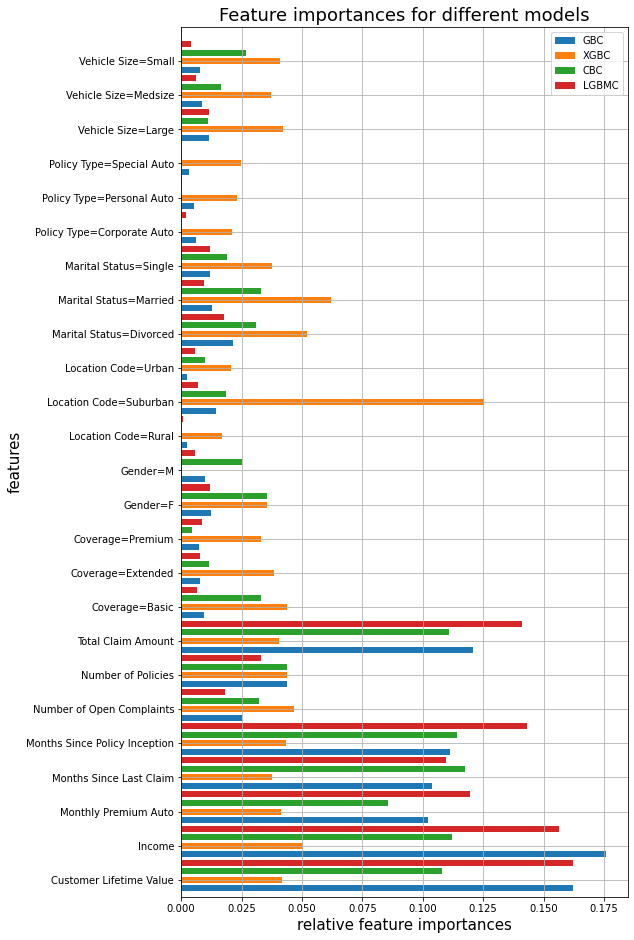

In [40]:
draw_models_feature_importances_h(best_models,X.columns)

# Заключение

В работе использовались следующие сокращения, по заглавным буквам в названии применяемых моделей:
- **GBC** &emsp; &nbsp;  для обозначения  *GradientBoostingClassifier* из sklearn.ensemble
- **XGBC** &ensp;&nbsp; для обозначения   *XGBClassifier* из xgboost
- **CBC** &emsp; &nbsp; для обозначения   *CatBoostClassifier* из catboost
- **LGBMC**&nbsp; для обозначения  *LGBMClassifier* из lightgbm

Опишем основные наблюдения, согласно проведенным вычислительным экспериментам. Основной метрикой сравнения моделей выбрали *roc_auc_score*.


1. Результаты из пункта 6.2.1 обучения и прогноза моделей с гиперпараметрами по умолчанию на разбиении из пункта 3.3 показало, что:
 - **LGBMC**, **CBC**, **XGBC** имеют близкий результат 0.99, 
 - **GBC** показал худший результат 0.88.  


2. Многократная кросвалидация моделей с гиперпараметрами по умолчанию в пункте 6.2.2 подтвердила, что на разбиении из пункта 3.3 
 - **XGBC**, **CBC**, **LGBMC** имеют лучший средний результат 0.99, 
 - **GBC** показал худший средний результат 0.89.
 

3. Модели с гиперпараметрами по умолчанию показали хороший результат, что видно при сравнении с результатами моделей с некоторым (неоптимальным) набором значений параметров в пункте 6.3.1
 - все модели имееют roc_auc_score не более 0.89
 - **GBC** показал лучший результат 0.88,
 - **XGBC** и **LGBMC** имеют близкий результат 0.85, 
 - **CBC** показал худший результат 0.78.


4. Перебор гиперпараметров с помощью *GridSearchCV* для рассматриваемых моделей показал, что:
 - на данном небольшом множестве данных выбранных данных все модели показали отличный результат (со своими оптимальными значениями гиперпараметров), 
 - на перебор параметров у моделей ушло **GBC** ~120 сек., **CBC** ~85 сек., **XGBC** ~25 сек., **LGBMC** ~9 cек. 
 

5. Полученные модели с оптимальными гиперпараметрами выбирали разный набор значимых признаков в данных для прогноза. Согласно пункту 6.4 следует обратить внимание на признаки: 
 - *Income*,
 - *Customer Lifetime Value*,
 - *Total Claim Amount*,
 - *Months Since Policy Inception*,
 - *Location Code(suburban)*, 
 - *Months Since Last Claim*.
 
 Для дальнейшего исследования задачи следует  рассмотреть неучтенные категориальные признаки (в пункте 2.2 была изъята из рассмотрения часть категориальных признаков). 

На выбранных данных лучше всего себя проявил **LGBMC**, так как показал наименьшее время работы, а по качеству (roc_auc_score) он не уступал другим моделям.